In [1]:
import powerlaw

In [2]:
powerlaw.Fit??

In [3]:
from net_analysis import *

In [4]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter
import powerlaw
from networkx.drawing.nx_agraph import graphviz_layout
import pickle
from statistics import mean, stdev
import seaborn as sns

In [5]:
path = "../Dataset FFF/edges.csv"
path1 = "../Dataset FFF/edges_3K.csv"

In [6]:
path_graph = "../Dataset FFF/Graph_data/"

# 1 - Real World network analysis

Read unidirect network:
for a unidirect network:
average degree < k > = 2L/N

In [7]:
G = nx.read_edgelist(path, comments = "S", delimiter = ",", data=(("Count", int),))

In [8]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 4147
Number of edges: 63400
Average degree:  30.5763


In [9]:
nx.write_graphml(G, path_graph+"Real_Network.graphml")

Maximum number of edges that a unidirect graph can contain:
Lmax = N(N-1)/2

In [10]:
N = G.number_of_nodes()
print("LMAX: ", (N * (N-1))/2.0)

LMAX:  8596731.0


Mean degree:
< k > = 2*L/N

In [11]:
avg_degree=(2*G.number_of_edges())/N
avg_degree

30.576320231492645

Network density:
d(G) = L/Lmax

In [12]:
density = nx.density(G)
print("Density: ", density)

Density:  0.0073748963414116365


For sparse network:
      L << Lmax     
      < k > << N-1  
      d(G) << 1  

Top 10 nodes by degree

In [13]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key = itemgetter(1), reverse = True)
print(" ---- Top 20 nodes by degree ----")
for d in sorted_degree[:20]:
    print("\t" + str(d))

 ---- Top 20 nodes by degree ----
	('windows-10', 1901)
	('linux', 1762)
	('windows', 1686)
	('ubuntu', 996)
	('networking', 891)
	('macos', 774)
	('command-line', 687)
	('google-chrome', 576)
	('windows-7', 569)
	('debian', 558)
	('powershell', 556)
	('hard-drive', 544)
	('bash', 522)
	('mac', 508)
	('usb', 492)
	('ssh', 489)
	('boot', 479)
	('wireless-networking', 474)
	('windows-11', 467)
	('security', 463)


In [14]:
len(sorted_degree)

4147

In [15]:
example_path = nx.shortest_path(G, source = "macos", target = "apm")
example_path

['macos', 'linux', 'apm']

Number of selfloops:

In [16]:
print("Number of selfloops:",nx.number_of_selfloops(G))

Number of selfloops: 0


Average clustering coefficient:

In [17]:
print("Avg Clustering coefficient:", nx.average_clustering(G))

Avg Clustering coefficient: 0.5831718074856295


Check if the network is connected

In [18]:
print("Is connected: ", nx.is_connected(G))

Is connected:  False


# 2 - Models construction

Barabási-Albert (scale-free - preferential attachment):
Function networkx.barabasi_albert_graph(n, m, seed) return a random graph according to the Barabàsi-Albert preferential attachment model.
A graph of n nodes is grown by attaching new nodes each with m edges that are preferentially attached to existing nodes with high degree. Where 1 <= m < n

Growth: While the random network model assumes that the number of nodes is fixed (time invariant), real networks are the result of a growth process that continuously increases.

Preferential Attachment: While nodes in random networks randomly choose their interaction partner, in real networks new nodes prefer to link to the more connected nodes.

In [19]:
ba_G = nx.read_graphml(path_graph+"BA_Network.graphml")

In [20]:
#ba_G = nx.barabasi_albert_graph(G.number_of_nodes(), 10, seed = 42)
print("Nodes:",ba_G.number_of_nodes())
print("Edges:",ba_G.number_of_edges())

Nodes: 4147
Edges: 28980


Watts-Strogatz (small-world):
Function watts_strogatz_graph(n, k, p, seed=None) return a Watts-Strogatz small-world graph. Where k = Each node is connected to k nearest neighbors in ring topology; p = The probability of rewiring each edge

A model to capture large clustering coefficient and short distances observed in real networks. From regular lattice (p=0)
..to random netwroks (p=1)..
.. passing by the small world regime (0.001 < p < 0.1)

In [21]:
ws_G = nx.read_graphml(path_graph+"WS_Network.graphml")

In [22]:
#ws_G = nx.watts_strogatz_graph(G.number_of_nodes(), k=20, p=0.1, seed = 42)
print("Nodes:",ws_G.number_of_nodes())
print("Edges:",ws_G.number_of_edges())

Nodes: 4147
Edges: 29029


Erdös–Rényi (random):
Function networkx.erdos_renyi_graph(n, p, seed=None, directed=True) return a random graph. The model chooses each of the possible edges with probability p.

A random graph is a graph of N nodes where each pair of nodes is connected by probability p. ER Regimes:

- Subcritical: regime <1, p < pc = 1/N
- Critical regime = 1, p=pc=1/N
- Supercritical regime ( > 1, p > pc=1/N )
- Connected regime ( > ln N, p > (ln N)/N)

In [23]:
er_G = nx.read_graphml(path_graph+"ER_Network.graphml")

In [24]:
#er_G = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())
print("Nodes:", er_G.number_of_nodes())
print("Edges:", er_G.number_of_edges())

Nodes: 4147
Edges: 8684


Configuration model:
creation Unidirected Configuration Model

In [25]:
cmodel = nx.read_graphml(path_graph+"CM_Network.graphml")

In [26]:
print("Nodes:", cmodel.number_of_nodes())
print("Edges:", cmodel.number_of_edges())

Nodes: 4147
Edges: 63400


In [27]:
models = {"Real Network": G,
          "Barabasi Albert": ba_G, 
          "Watts Strogatz": ws_G, 
          "Erdos Renyi": er_G, 
          "Configuration Model": cmodel
         }

# 3 - Degree Distribution

Visualize the digree distribution

In [28]:
def degree_dist(G, name):
    hist = nx.degree_histogram(G)
    plt.plot(range(0, len(hist[4:])), hist[4:], ".")
    plt.title(f"Degree Distribution for {name} graph")
    plt.xlabel("Degree")
    plt.ylabel("P(k)")
    plt.loglog()
    plt.show()

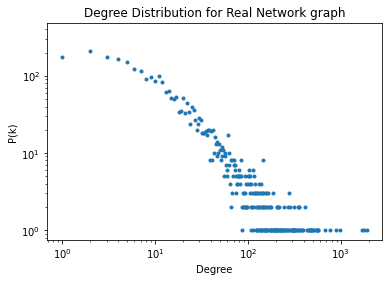

In [29]:
degree_dist(models["Real Network"], "Real Network")

Degree distribution with powerlaw fit

Calculating best minimal value for power law fit
**** Degree Distribution for Real Network graph ****


C:\Users\marco\Documents\sna-project-2022_cosmo_d-arrigo_esposito\2 - NetworkAnalysis\net_analysis.py:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim((min(degree), max(degree)))


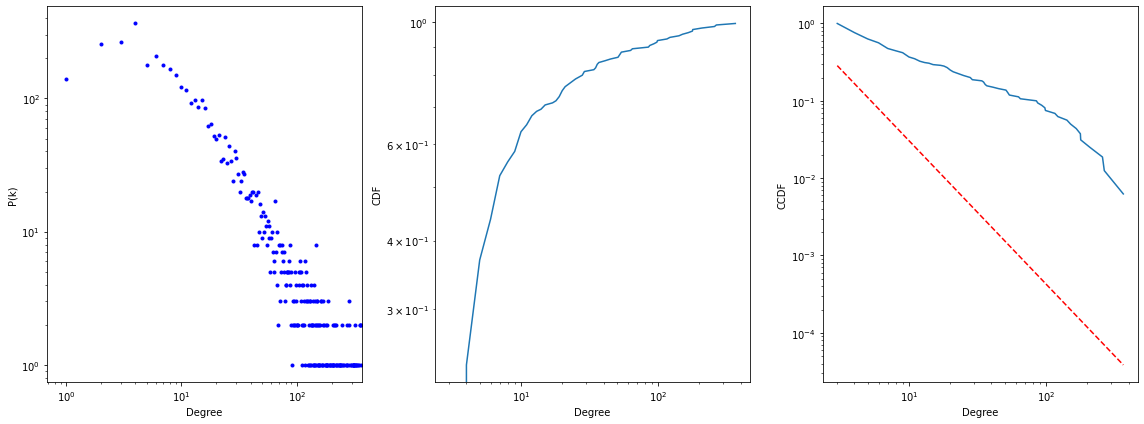

alpha=2.855030926329605 sigma=0.06759612992712964


In [38]:
plot_dist(models["Real Network"], "Real Network","/")

Degree info

In [39]:
def info_degree(G, name):
    print(f"***** Degree info for {name} graph ***")
    degree_sequence = sorted([(d, n) for n, d in G.degree()], reverse=True)
    dmax = max(degree_sequence)
    print("Maximum degree:", dmax)
    dmin = min(degree_sequence)
    print("Minimum degree:", dmin)

In [40]:
info_degree(models["Real Network"], "Real Network")

***** Degree info for Real Network graph ***
Maximum degree: (1901, 'windows-10')
Minimum degree: (1, 'address-space-exhaustion')


Degree distribution plot

In [41]:
def degree_dist_plot(models):
    graphs = []
    for model in models:
        graphs.append((models[model], model))
    fig = plt.figure(figsize=(16,8), dpi= 300)
    labels = []
    for i in graphs:
        print(f"Network - {i[1]}")
        degrees = i[0].degree()
        values = sorted(set([v for k, v in degrees]))
        hist = [[v for k, v in degrees].count(x) for x in values]
        labels.append(i[1])
        if(i[1] == "Real Network"):
            plt.loglog(values, hist, 'o-')
        else:
            plt.loglog(values, hist, 'o')
    fontsize = 15
    plt.yticks(fontsize=fontsize, alpha=1)
    plt.xlabel("Degree", fontsize=fontsize)
    plt.ylabel("Number of nodes", fontsize=fontsize)
    plt.title("Degree Distribution", fontsize=fontsize)
    plt.legend(labels, fontsize=fontsize)
    plt.grid(axis='both', alpha=.3)
    
    plt.xlim([0, 2*10**2])

    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)   
    plt.show()

The real world degree distribution is very similar to configuration model

Network - Real Network
Network - Barabasi Albert
Network - Watts Strogatz
Network - Erdos Renyi
Network - Configuration Model


<ipython-input-41-db40942b10a8>:25: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 2*10**2])


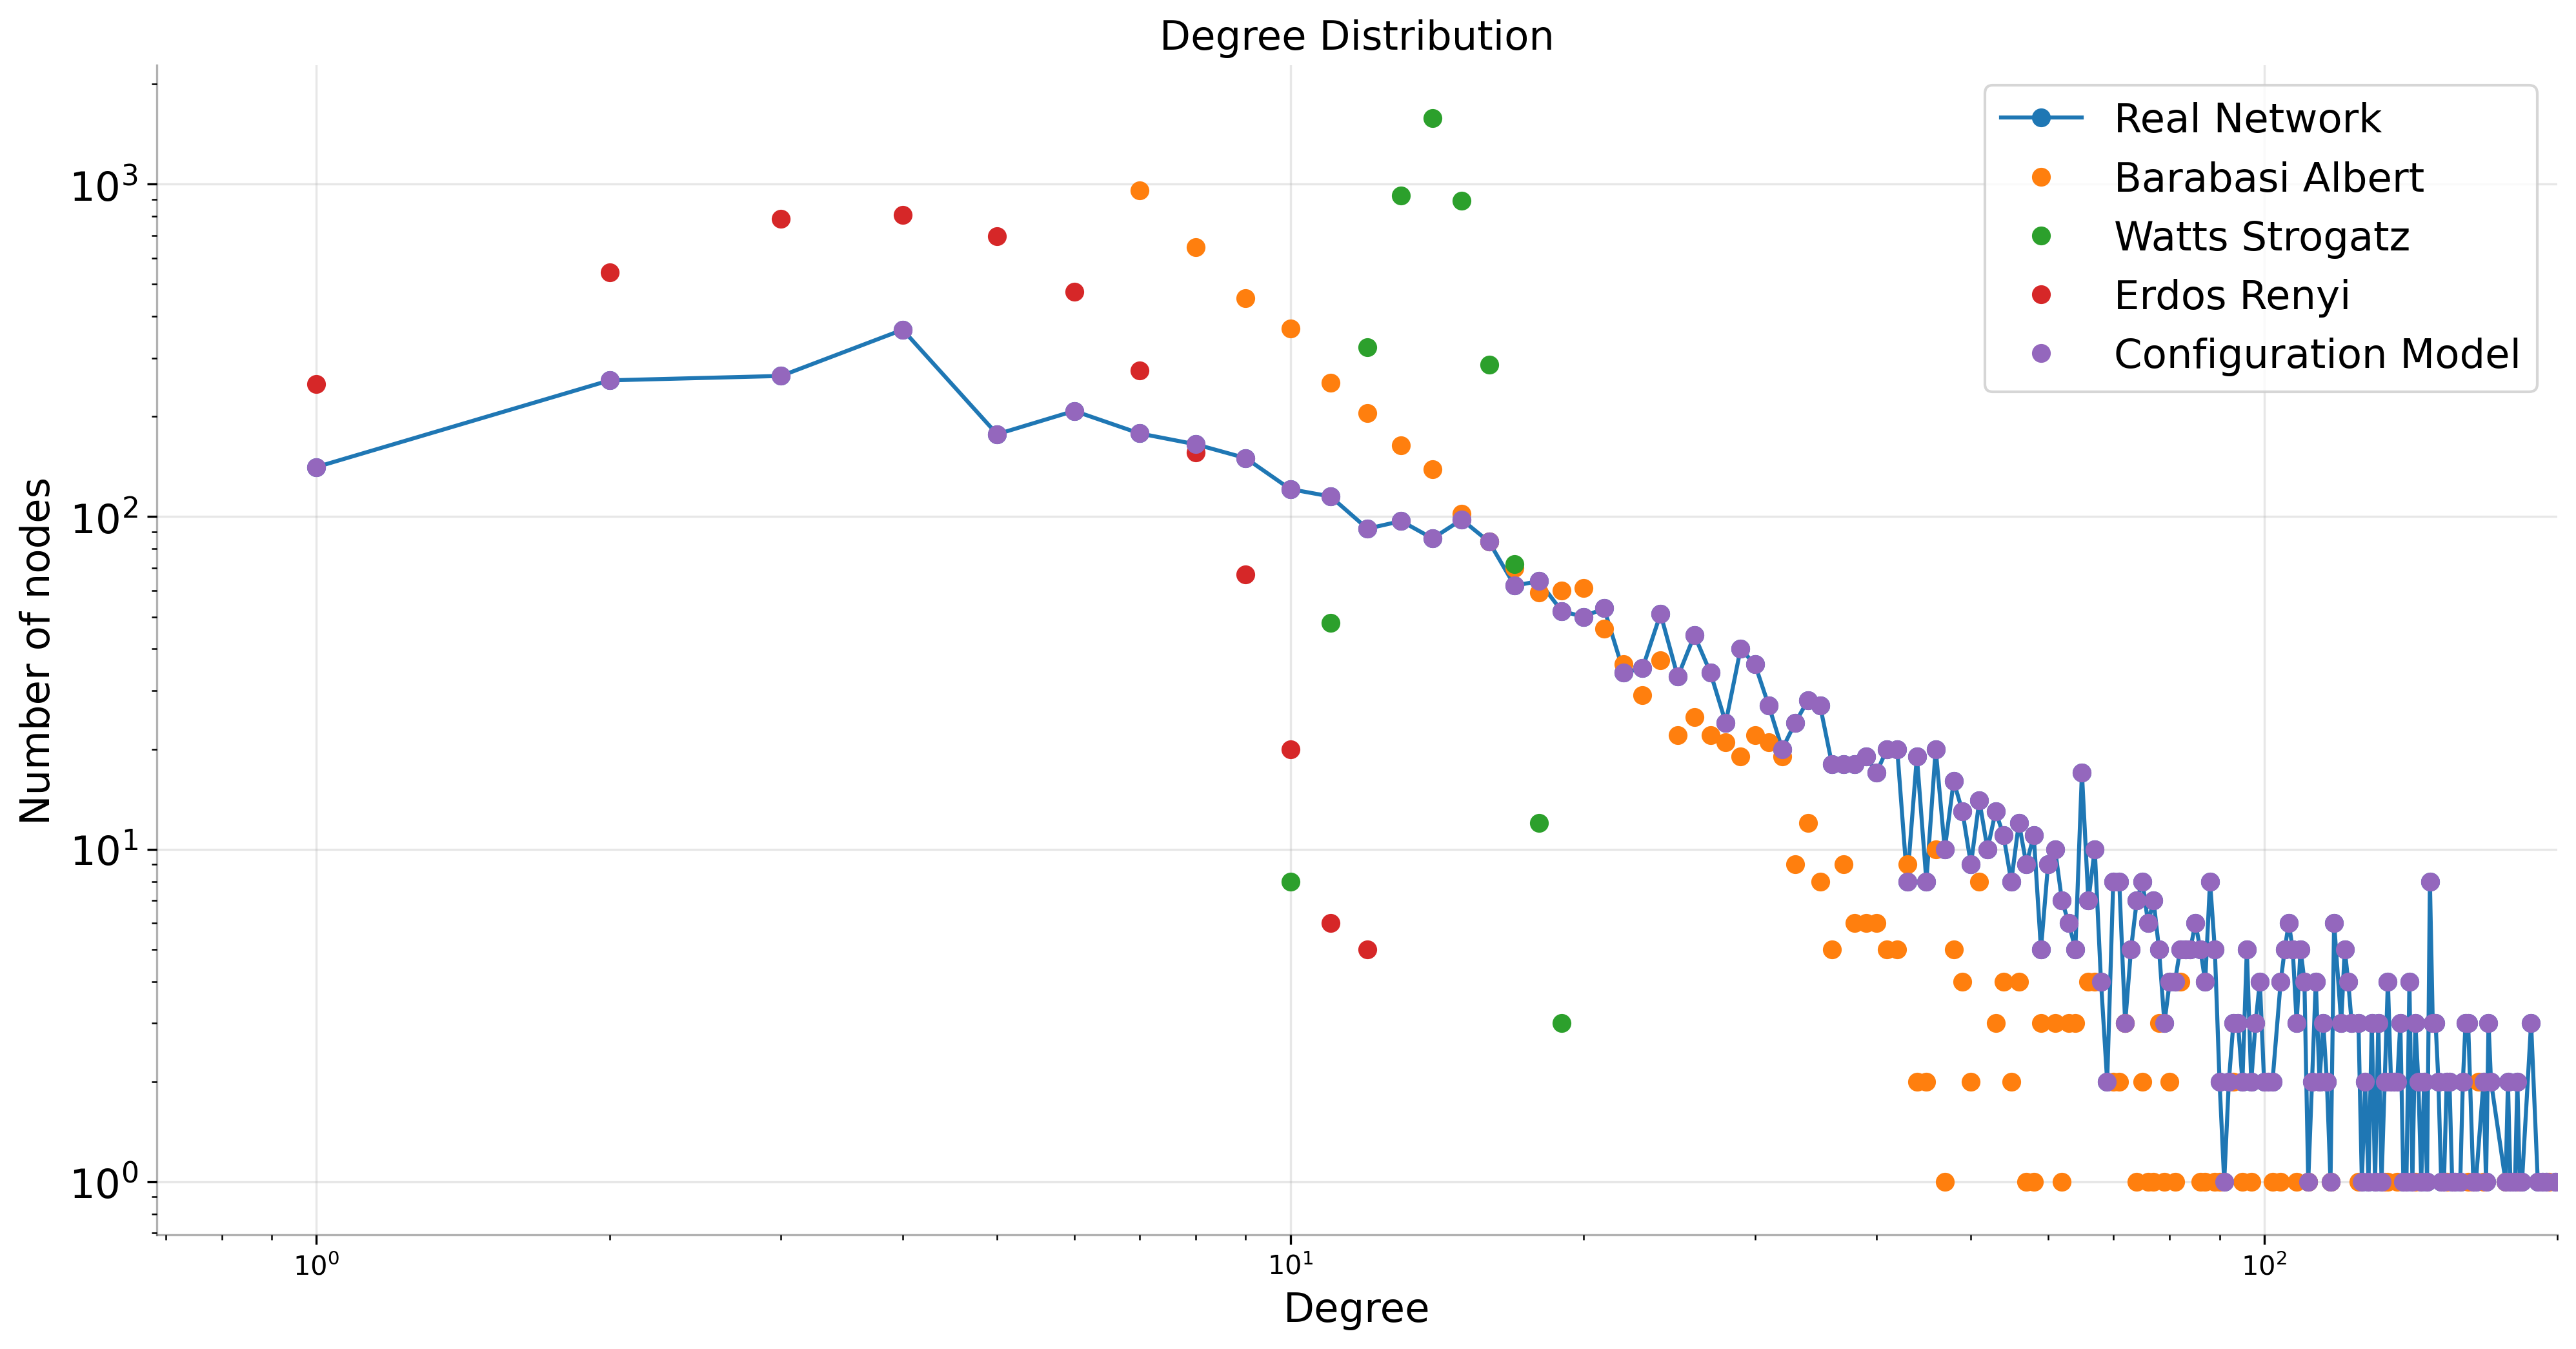

In [42]:
degree_dist_plot(models)

# 4 - Connected Components

In [43]:
def n_connected_components(G, name):
    print(f"**** Connected components for {name} graph ****")
    # list of connected components
    n_connected_component = list(nx.connected_components(G))
    print(f"Number of Connected Components for {name}: {len(n_connected_component)}")
    for i in range(len(n_connected_component)):
        if i < 3:
            print(f"\t component len = {len(n_connected_component[i])}")
    # Giant component -> Identify and store giant component
    H = nx.Graph()
    H = nx.subgraph(G,n_connected_component[0])
    nx.write_graphml(H, path_graph+"giant_component/"+ name+".graphml")
    return n_connected_component


In [44]:
components = n_connected_components(models["Real Network"], "Real Network")

**** Connected components for Real Network graph ****
Number of Connected Components for Real Network: 3
	 component len = 4143
	 component len = 2
	 component len = 2


# 5 - Path Analysis

Shortest Path

In [45]:
def path_analysis(G, name, components):
    print(f"***** Path analysis for {name} graph")
    print(f"Diameter for components 0 network {name}: {nx.diameter(G.subgraph(components[0]))}")
    print(f"Average shortest path for components 0 network {name}: {nx.average_shortest_path_length(G.subgraph(components[0]))}")
    

In [46]:
path_analysis(models["Real Network"], "Real Network", components)

***** Path analysis for Real Network graph
Diameter for components 0 network Real Network: 6
Average shortest path for components 0 network Real Network: 2.527067174676256


In [47]:
print(f"Average shortest path for components 0 network Real Network weighted: {nx.average_shortest_path_length(G.subgraph(components[0]), weight='Count')}")


Average shortest path for components 0 network Real Network weighted: 2.8326444761532805


# 6 - Clustering Coefficient

Average clustering coefficient

In [48]:
G_cc = nx.average_clustering(G)
print('Real world average cluster coefficient: ' + str(G_cc) + '\n')

Real world average cluster coefficient: 0.5831718074856295



# Clustering coefficient distribution

The avarage clustering for the cm cannot be calculated because it is a multigraph (the function always returns a multigraph)

In [49]:
def degree_clustering(G, name):
    print(f"**** Distribution degree/clustering for {name} graph ***")
    degrees = G.degree()
    local_clustering_coefficient= []
    degree = []

    for d in degrees:
        local_clustering_coefficient.append(nx.clustering(G,d[0]))
        #print(local_clustering_coefficient)
        degree.append(d[1])
        
    plt.figure(figsize=(20,5))
    plt.scatter(degree, local_clustering_coefficient)

    plt.xlabel("k")
    plt.ylabel("C(k)")

    plt.show()

**** Distribution degree/clustering for Real Network graph ***


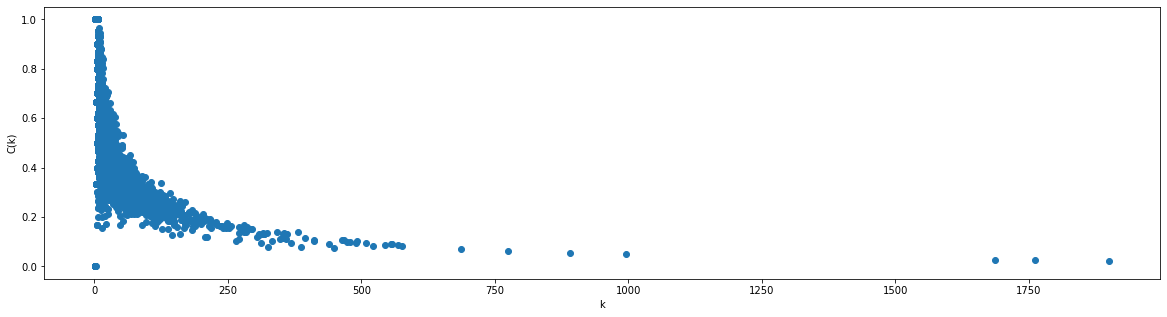

In [50]:
#for model in models:
#    degree_clustering(models[model], model)
degree_clustering(models["Real Network"], "Real Network")

In [51]:
def c_coefficient_analysis(G, name):
    clustering_g = nx.clustering(G)
    print(f"*** Clustering coefficient analysis for {name} graph ***")
    #print(f"CC: {clustering_g.values()}")
    print(f"Min: {min(clustering_g.values())}")
    print(f"Max: {max(clustering_g.values())}")
    print(f"Mean: {mean(clustering_g.values())}")
    print(f"Stdev: {stdev(clustering_g.values())}")
    return (name, clustering_g.values())

In [52]:
name, clustering_g = c_coefficient_analysis(models["Real Network"], "Real Network")

*** Clustering coefficient analysis for Real Network graph ***
Min: 0
Max: 1.0
Mean: 0.5831718074856291
Stdev: 0.2802349517757865
